In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as io
from skimage import feature
from skimage.transform import resize
from sklearn.feature_selection import VarianceThreshold
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skimage.filters import gabor
from skimage.feature import corner_fast, corner_peaks, corner_harris
import sys
import os
sys.path.append('../')
import helpers.histogram_classifier as hc

In [2]:
def sub_grid(image, size=32):
    """
    Split an image into a grid of non-overlapping square boxes, and return each box in turn
    :params image: image as numpy array
    :params size: side-length of box to use; should be a power of 2
    :return: yields each box in turn
    """
    pic_size = image.shape
    box_side = size
    for x in range(0, pic_size[0], box_side):
        for y in range(0, pic_size[1], box_side):
            yield image[x:x + box_side, y:y + box_side, :]

In [3]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def get_image_features(img, box_size):
    """
    Get RGB and edge features for a single image by splitting the image into a grid of non-overlapping
    square boxes, and obtaining features for each box
    :params img: image as a numpy array
    :params box_size: the side-length in pixels of the box to be used
    :return: mean Red pixel value in each box
    :return: mean Green pixel value in each box
    :return: mean Blue pixel value in each box
    :return: number of edges in each box, extracted using skimage canny edges algorithm
    :return: number of corners in each box, extracted using skimage corner_fast algorithm
    """
    image_features = []
    for box in sub_grid(img, size=box_size):
        features = []
        features.append(np.mean(box[:, :, 0]))
        features.append(np.mean(box[:, :, 1]))
        features.append(np.mean(box[:, :, 2]))
        features.append(np.sum(feature.canny(rgb2gray(box), sigma=1)))
        features.append(corner_peaks(corner_fast(rgb2gray(box))).shape[0])
        image_features.append(np.array(features))
    image_features = np.array(image_features)
    return image_features[:, 0], image_features[:, 1], image_features[:, 2], image_features[:, 3], image_features[:, 4]

In [5]:
def get_complete_features(image_classes, image_names, box_size):
    """
    Get RGB and edge features for a dictionary of image names
    :params image_classes: list of n image classes
    :params image_names: dictionary of m image names for each class
    :params size: size as tuple for reshaping images for extracting edges and corners
    :return: red_features: average red pixel value for each box in each image
    :return: green_features: average green pixel value for each box in each image
    :return: blue_features: average blue pixel value for each box in each image
    :return: edge_features: number of edges detected for each box in each image
    :return: corner_features: number of corners detected for each box in each image
    :return: labels: array of true labels for each image
    """
    red_features = []
    green_features = []
    blue_features = []
    edge_features = []
    corner_features = []
    labels = []
    for c in image_classes:
        for i in image_names[c]:
            img = io.imread(os.path.join("../data/food-101/top_classes/", c, "", i))
            red, green, blue, edge, corners = get_image_features(img, box_size=box_size)
            red_features.append(red)
            green_features.append(green)
            blue_features.append(blue)
            edge_features.append(edge)
            corner_features.append(corners)
            labels.append(c)
    
    return np.array(red_features), np.array(green_features), np.array(blue_features), np.array(edge_features), np.array(corner_features), np.array(labels)

In [6]:
PCA_components = 256
BOX = 32

In [7]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [8]:
dev_image_names = {}
for c in class_list:
    dev_image_names[c] = image_names[c][:10]

In [8]:
train, test = hc.split_data(image_names, 0.75)

In [9]:
#Get complete histogram features, edge and corners
all_red_features, all_green_features, all_blue_features, all_edge_features, all_corner_features, train_labels = get_complete_features(class_list, train, BOX)

In [10]:
#Get top features using PCA for red features
if all_red_features.shape[1] > PCA_components:
    red_pca = PCA(n_components=PCA_components)
    red_pca.fit(all_red_features)
    final_red_features = red_pca.transform(kept_red_features)
else:
    final_red_features = all_red_features

In [11]:
#Get top features using PCA for green features
if all_green_features.shape[1] > PCA_components:
    green_pca = PCA(n_components=PCA_components)
    green_pca.fit(all_green_features)
    final_green_features = green_pca.transform(all_green_features)
else:
    final_green_features = all_green_features

In [12]:
#Get top features using PCA for blue features
if all_blue_features.shape[1] > PCA_components:
    blue_pca = PCA(n_components=PCA_components)
    blue_pca.fit(all_blue_features)
    final_blue_features = blue_pca.transform(all_blue_features)
else:
    final_blue_features = all_blue_features

In [13]:
#Get top features using PCA for edge features
if all_edge_features.shape[1] > PCA_components:
    edge_pca = PCA(n_components=PCA_components)
    edge_pca.fit(all_edge_features)
    final_edge_features = edge_pca.transform(all_edge_features)
else:
    final_edge_features = all_edge_features

In [14]:
#Get top features using PCA for corner features
if all_corner_features.shape[1] > PCA_components:
    corner_pca = PCA(n_components=PCA_components)
    corner_pca.fit(all_corner_features)
    final_corner_features = corner_pca.transform(all_corner_features)
else:
    final_corner_features = all_corner_features

In [15]:
all_features = np.concatenate((final_red_features, final_green_features, final_blue_features, final_edge_features, final_corner_features), axis=1)

In [16]:
#Setup grid-search for top parameters
depth = np.array([8, 10, 12, 14])
estimators = np.array([10, 25, 50, 100, 250, 500])
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=estimators, max_depth=depth))

In [17]:
grid.fit(all_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 8, 10, 12, 14]), 'n_estimators': array([ 10,  25,  50, 100, 250, 500])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
print("Best score = {}".format(grid.best_score_))
print("N_estimators: {}".format(grid.best_estimator_.n_estimators))
print("Max depth: {}".format(grid.best_estimator_.max_depth))

Best score = 0.328
N_estimators: 500
Max depth: 14


In [19]:
%%time
rf = RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, max_depth=grid.best_estimator_.max_depth)
rf.fit(all_features, train_labels)

CPU times: user 1min 38s, sys: 367 ms, total: 1min 39s
Wall time: 1min 39s


In [20]:
#Get Test Features
all_red_features_t, all_green_features_t, all_blue_features_t, all_edge_features_t, all_corner_features_t, test_labels = get_complete_features(class_list, test, BOX)

In [21]:
if all_red_features_t.shape[1] > PCA_components:
    final_red_t = red_pca.transform(all_red_features_t)
else:
    final_red_t = all_red_features_t

if all_green_features_t.shape[1] > PCA_components:
    final_green_t = green_pca.transform(all_green_features_t)
else:
    final_green_t = all_green_features_t
    
if all_blue_features_t.shape[1] > PCA_components:
    final_blue_t = blue_pca.transform(all_blue_features_t)
else:
    final_blue_t = all_blue_features_t

if all_edge_features_t.shape[1] > PCA_components:
    final_edge_t = edge_pca.transform(all_edge_features_t)
else:
    final_edge_t = all_edge_features_t
    
if all_corner_features_t.shape[1] > PCA_components:
    final_corner_t = corner_pca.transform(all_corner_features_t)
else:
    final_corner_t = all_corner_features_t

In [22]:
final_test_features = np.concatenate((final_red_t, final_green_t, final_blue_t, final_edge_t, final_corner_t), axis=1)

In [23]:
%%time
predicted_labels = rf.predict(final_test_features)

CPU times: user 682 ms, sys: 92.8 ms, total: 775 ms
Wall time: 774 ms


In [24]:
%%time
predicted_probabilities = rf.predict_proba(final_test_features)

CPU times: user 744 ms, sys: 78 ms, total: 822 ms
Wall time: 826 ms


In [25]:
overall, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)

In [26]:
overall

,Accuracy,F1,Precision,Recall
Results,0.316,0.306,0.309,0.316


In [27]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.29,0.29,0.29,250.0
lasagna,0.31,0.21,0.25,250.0
french_toast,0.37,0.28,0.32,250.0
guacamole,0.28,0.32,0.30,250.0
apple_pie,0.19,0.14,0.16,250.0
cheesecake,0.35,0.50,0.41,250.0
hamburger,0.30,0.23,0.26,250.0
fried_rice,0.35,0.46,0.39,250.0
carrot_cake,0.26,0.16,0.20,250.0
chocolate_cake,0.36,0.36,0.36,250.0


In [28]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,73,16,11,14,5,11,10,18,11,19,52,10
lasagna,16,53,20,24,24,12,7,28,10,8,7,41
french_toast,17,22,70,12,17,7,15,25,11,7,18,29
guacamole,13,6,4,79,11,17,18,39,14,9,16,24
apple_pie,7,15,10,21,35,49,31,26,17,8,8,23
cheesecake,5,4,2,14,19,126,7,6,15,39,7,6
hamburger,17,11,11,26,22,23,58,22,7,16,20,17
fried_rice,9,8,7,28,12,13,8,115,8,1,6,35
carrot_cake,23,10,17,22,19,41,11,16,41,15,17,18
chocolate_cake,16,2,13,12,3,41,13,1,10,91,42,6


In [29]:
plt.style.use('ggplot')

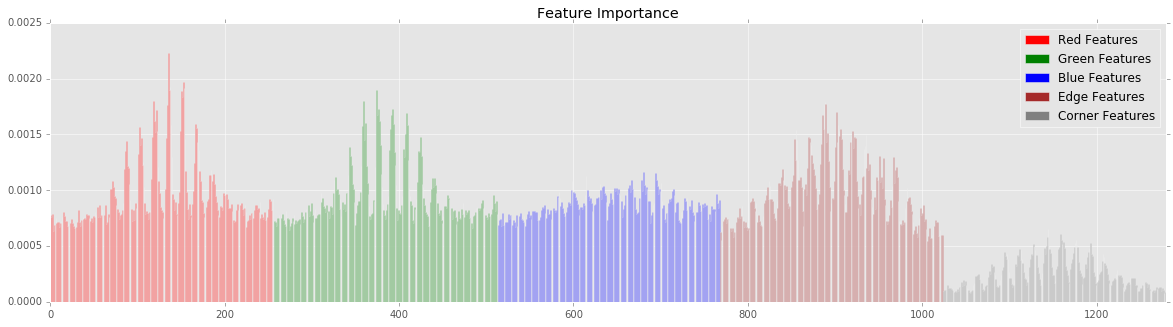

In [30]:
fig, ax = plt.subplots(figsize=(20,5))

num_red = final_red_features.shape[1]
num_green = final_green_features.shape[1]
num_blue = final_blue_features.shape[1]
num_edges = final_edge_features.shape[1]
num_corners = final_corner_features.shape[1]
x = [num_red, num_red + num_green, num_red + num_green + num_blue, num_red + num_green + num_blue + num_edges, num_red + num_green + num_blue + num_edges + num_corners]
ax.bar([i for i in range(x[0])], rf.feature_importances_[:x[0]], color='red', label='Red Features')
ax.bar([i for i in range(x[0], x[1])], rf.feature_importances_[x[0]:x[1]], color='green', label='Green Features')
ax.bar([i for i in range(x[1], x[2])], rf.feature_importances_[x[1]:x[2]], color='blue', label='Blue Features')
ax.bar([i for i in range(x[2], x[3])], rf.feature_importances_[x[2]:x[3]], color='brown', label='Edge Features')
ax.bar([i for i in range(x[3], x[4])], rf.feature_importances_[x[3]:x[4]], color='grey', label='Corner Features')
ax.set_title("Feature Importance")
ax.set_xlim(0,x[4])
ax.legend()
plt.show()

In [12]:
from sklearn.externals import joblib

In [32]:
file_name = "../models/features_3/rf_classifier.pkl"

In [34]:
joblib.dump(rf, file_name)

['../models/features_3/rf_classifier.pkl',
 '../models/features_3/rf_classifier.pkl_01.npy',
 '../models/features_3/rf_classifier.pkl_02.npy',
 '../models/features_3/rf_classifier.pkl_03.npy',
 '../models/features_3/rf_classifier.pkl_04.npy',
 '../models/features_3/rf_classifier.pkl_05.npy',
 '../models/features_3/rf_classifier.pkl_06.npy',
 '../models/features_3/rf_classifier.pkl_07.npy',
 '../models/features_3/rf_classifier.pkl_08.npy',
 '../models/features_3/rf_classifier.pkl_09.npy',
 '../models/features_3/rf_classifier.pkl_10.npy',
 '../models/features_3/rf_classifier.pkl_11.npy',
 '../models/features_3/rf_classifier.pkl_12.npy',
 '../models/features_3/rf_classifier.pkl_13.npy',
 '../models/features_3/rf_classifier.pkl_14.npy',
 '../models/features_3/rf_classifier.pkl_15.npy',
 '../models/features_3/rf_classifier.pkl_16.npy',
 '../models/features_3/rf_classifier.pkl_17.npy',
 '../models/features_3/rf_classifier.pkl_18.npy',
 '../models/features_3/rf_classifier.pkl_19.npy',
 '../mo

In [40]:
test_data = []
j = 0
for c in class_list:
    for i in test[c]:
        test_data.append([test_labels[j], predicted_labels[j], i])
        j += 1

In [42]:
test_data = np.array(test_data)

In [43]:
test_data.dump("../models/features_3/test_data")

In [38]:
test_labels.dump("../models/features_3/test_labels")

In [39]:
predicted_labels.dump("../models/features_3/predicted_labels")

In [4]:
test_data = np.load("../models/features_3/test_data")
test_labels = np.load("../models/features_3/test_labels")

In [6]:
predicted_labels = np.load("../models/features_3/predicted_labels")

In [9]:
score, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)
score

,Accuracy,F1,Precision,Recall
Results,0.316,0.306,0.309,0.316


In [32]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.29,0.29,0.29,250.0
lasagna,0.31,0.21,0.25,250.0
french_toast,0.37,0.28,0.32,250.0
guacamole,0.28,0.32,0.30,250.0
apple_pie,0.19,0.14,0.16,250.0
cheesecake,0.35,0.50,0.41,250.0
hamburger,0.30,0.23,0.26,250.0
fried_rice,0.35,0.46,0.39,250.0
carrot_cake,0.26,0.16,0.20,250.0
chocolate_cake,0.36,0.36,0.36,250.0


In [10]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,73,16,11,14,5,11,10,18,11,19,52,10
lasagna,16,53,20,24,24,12,7,28,10,8,7,41
french_toast,17,22,70,12,17,7,15,25,11,7,18,29
guacamole,13,6,4,79,11,17,18,39,14,9,16,24
apple_pie,7,15,10,21,35,49,31,26,17,8,8,23
cheesecake,5,4,2,14,19,126,7,6,15,39,7,6
hamburger,17,11,11,26,22,23,58,22,7,16,20,17
fried_rice,9,8,7,28,12,13,8,115,8,1,6,35
carrot_cake,23,10,17,22,19,41,11,16,41,15,17,18
chocolate_cake,16,2,13,12,3,41,13,1,10,91,42,6


In [16]:
import seaborn as sns

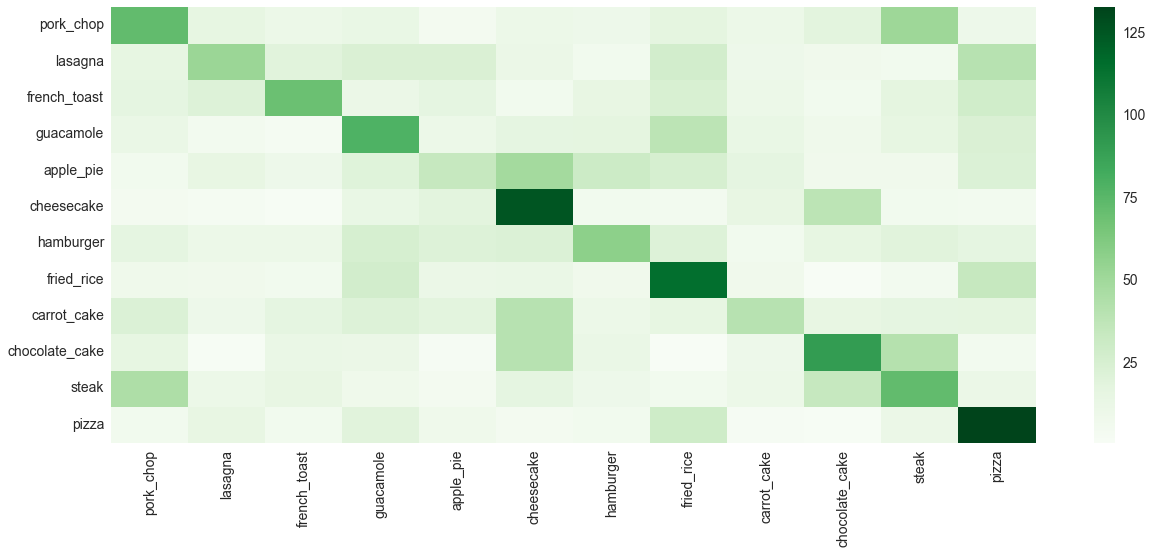

In [34]:
fig, ax = plt.subplots(figsize=(18,8))
sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, cmap='Greens')
fig.tight_layout()
plt.savefig('../reports/images/charts/machine_learning_confusion.pdf', format='pdf', dpi=1200)